# Experiment with U-net segmentation

Import packages

In [1]:
import os
import random

from PIL import Image
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import load_img, img_to_array

2025-06-11 21:27:32.717801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-11 21:27:32.731670: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-11 21:27:32.731692: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-11 21:27:32.740957: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-11 21:27:33.769868: W tensorflow/compiler/tf

In [2]:
import matplotlib.pyplot as plt

def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    
    return (ax1, ax2)

Define directories for dataset

In [3]:
image_dir1 = "../raw_data/segmentation/first_dataset/TIFF"
mask_dir1 = "../raw_data/segmentation/first_dataset/Mask"

IMG_SIZE = (224, 224)

In [4]:
VALID_IMAGE_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')

def load_data(image_dir, mask_dir, image_size=IMG_SIZE):
    images, masks = [], []

    for filename in os.listdir(image_dir):
        if not filename.lower().endswith(VALID_IMAGE_EXTENSIONS):
            continue  # Skip non-image files

        img_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename)

        try:
            # Load image
            img = load_img(img_path, target_size=image_size)
            img = img_to_array(img) / 255.0

            # Load mask or create blank
            if os.path.exists(mask_path):
                mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")
                mask = img_to_array(mask) / 255.0
                mask = np.round(mask)
            else:
                mask = np.zeros((image_size[0], image_size[1], 1), dtype=np.float32)

            images.append(img)
            masks.append(mask)

        except Exception as e:
            print(f"Skipping {filename}: {e}")

    return np.array(images), np.array(masks)

In [5]:
X, y = load_data(image_dir1, mask_dir1)
X.shape

(511, 224, 224, 3)

Visualize an image

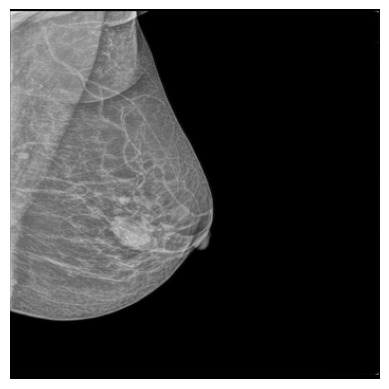

In [6]:
sample_image_path = image_dir1 + "/IMG001.png"
sample_image = Image.open(sample_image_path).resize((350, 350))
plt.imshow(sample_image)
plt.axis('off')  # Turn off the axes for a cleaner visualization
plt.show()

## Setup model: U-net

In [7]:
# from tensorflow.keras import layers, Model

# def unet_model(input_size=(IMG_SIZE[0], IMG_SIZE[1], 3), dropout_rate = 0.2):
#     inputs = layers.Input(input_size)
    
#     # Encoder
#     c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(inputs)
#     c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
#     d2 = layers.Dropout(dropout_rate)(c2)
#     p2 = layers.MaxPooling2D((2, 2))(d2)

#     c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
#     c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
#     d3 = layers.Dropout(dropout_rate)(c3)
#     p3 = layers.MaxPooling2D((2, 2))(d3)

#     c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
#     c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
#     d4 = layers.Dropout(dropout_rate)(c4)
#     p4 = layers.MaxPooling2D((2, 2))(d4)

#     # Bottleneck
#     c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
#     c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)
#     d5 = layers.Dropout(dropout_rate)(c5)
    
#     # Decoder
#     u6 = layers.UpSampling2D()(d5)
#     u6 = layers.concatenate([u6, c4])
#     c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
#     c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

#     u7 = layers.UpSampling2D()(c6)
#     u7 = layers.concatenate([u7, c3])
#     c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
#     c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

#     u8 = layers.UpSampling2D()(c7)
#     u8 = layers.concatenate([u8, c2])
#     c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
#     c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)
    

#     outputs = layers.Conv2D(1, 1, activation='sigmoid')(c8)

#     model = Model(inputs, outputs)
#     return model

In [8]:
from tensorflow.keras import layers, Model

def conv_block(x, filters, dropout_rate=0.0):
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
    
    return x

def unet_model(input_size=(IMG_SIZE[0], IMG_SIZE[1], 3), dropout_rate=0.2):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256, dropout_rate)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 512, dropout_rate)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    bn = conv_block(p4, 1024, dropout_rate)

    # Decoder
    u4 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(bn)
    u4 = layers.concatenate([u4, c4])
    c5 = conv_block(u4, 512)

    u3 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(c5)
    u3 = layers.concatenate([u3, c3])
    c6 = conv_block(u3, 256)

    u2 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c6)
    u2 = layers.concatenate([u2, c2])
    c7 = conv_block(u2, 128)

    u1 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c7)
    u1 = layers.concatenate([u1, c1])
    c8 = conv_block(u1, 64)

    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c8)

    return Model(inputs, outputs)

Loss

In [9]:
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [10]:
from tensorflow.keras.losses import BinaryCrossentropy

def bce_dice_loss(y_true, y_pred):
    bce = BinaryCrossentropy()(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

Metrics

In [11]:
import tensorflow.keras.backend as K
import tensorflow as tf

threshold = 0.3

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_bin = K.cast(y_pred > threshold, tf.float32)  # Binarize predictions
    y_pred_f = K.flatten(y_pred_bin)

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, tf.float32)
    y_pred = K.cast(y_pred > threshold, tf.float32)  # binarize predictions

    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def precision_metric(y_true, y_pred):
    y_pred_bin = K.cast(y_pred > threshold, tf.float32)
    y_true = K.cast(y_true, tf.float32)

    true_positives = K.sum(y_true * y_pred_bin)
    predicted_positives = K.sum(y_pred_bin)
    
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_metric(y_true, y_pred):
    y_pred_bin = K.cast(y_pred > threshold, tf.float32)
    y_true = K.cast(y_true, tf.float32)

    true_positives = K.sum(y_true * y_pred_bin)
    actual_positives = K.sum(y_true)
    
    recall = true_positives / (actual_positives + K.epsilon())
    return recall

Compile

In [12]:
from keras import optimizers


def build_model():
    model = unet_model()
    model.compile(loss=bce_dice_loss, 
                  optimizer = optimizers.Adam(learning_rate=1e-2), 
                  metrics = [dice_coef, iou_metric, precision_metric, recall_metric])

    return model

In [13]:
#build_model().summary()

In [14]:
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau

model = build_model()

#es = EarlyStopping(monitor = "iou_metric", patience = 30, restore_best_weights=True, mode="max")

# def lr_scheduler(epoch, lr):
#     decay_rate = 0.97
#     decay_step = 5
#     if epoch % decay_step == 0 and epoch:
#         return lr * pow(decay_rate, np.floor(epoch / 2*decay_step))
#     return lr

lr_scheduler = ReduceLROnPlateau(
    monitor='iou_metric',      # or 'val_dice_coef' / 'val_iou_metric'
    factor=0.5,              # reduce by this factor
    patience=20,              # wait this many epochs before reducing
    min_lr=1e-6,             # don't go below this
    verbose=1
)

with tf.device("/GPU:0"):
    history = model.fit(X,y,
                        batch_size=32,
                        epochs=500,
                        callbacks=[lr_scheduler], #LearningRateScheduler(lr_scheduler, verbose=1)],
                        verbose=1)

2025-06-11 21:27:40.355672: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-11 21:27:40.418337: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-11 21:27:40.418383: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-11 21:27:40.421169: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-11 21:27:40.421217: I external/local_xla/xla/stream_executor

Epoch 1/500


I0000 00:00:1749670069.252497  261402 service.cc:145] XLA service 0x7ff4800419b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749670069.252540  261402 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-06-11 21:27:49.448043: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-11 21:27:50.330248: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-06-11 21:28:09.873234: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng58{k2=4,k5=2,k14=3} for conv (f32[32,128,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,224,224]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - dice_coef: 0.0464 - iou_metric: 0.0265 - loss: 1.4068 - precision_metric: 0.0355 - recall_metric: 0.4124

2025-06-11 21:29:17.816471: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng58{k2=8,k12=6,k13=1,k14=1,k15=0,k17=7,k18=1,k23=0} for conv (f32[128,128,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,128,112,112]{3,2,1,0}, f32[31,128,112,112]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-06-11 21:29:17.848445: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.799856775s
Trying algorithm eng58{k2=8,k12=6,k13=1,k14=1,k15=0,k17=7,k18=1,k23=0} for conv (f32[128,128,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,128,112,112]{3,2,1,0}, f32[31,128,112,112]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$

16/16 ━━━━━━━━━━━━━━━━━━━━ 113s 4s/step - dice_coef: 0.0542 - iou_metric: 0.0312 - loss: 1.3788 - precision_metric: 0.0421 - recall_metric: 0.4044 - learning_rate: 0.0100
Epoch 2/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 409ms/step - dice_coef: 0.2436 - iou_metric: 0.1428 - loss: 0.9016 - precision_metric: 0.2113 - recall_metric: 0.4459 - learning_rate: 0.0100
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 410ms/step - dice_coef: 0.2311 - iou_metric: 0.1356 - loss: 0.8793 - precision_metric: 0.2000 - recall_metric: 0.5872 - learning_rate: 0.0100
Epoch 4/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 526ms/step - dice_coef: 0.2947 - iou_metric: 0.1768 - loss: 0.7920 - precision_metric: 0.2651 - recall_metric: 0.4219 - learning_rate: 0.0100
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 412ms/step - dice_coef: 0.3124 - iou_metric: 0.1888 - loss: 0.7859 - precision_metric: 0.3317 - recall_metric: 0.4344 - learning_rate: 0.0100
Epoch 6/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 411ms/step - dice_coef: 0.2640 - iou_metric: 0.1567

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 419ms/step - dice_coef: 0.4873 - iou_metric: 0.3269 - loss: 0.5698 - precision_metric: 0.6564 - recall_metric: 0.4260 - learning_rate: 0.0050
Epoch 38/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 544ms/step - dice_coef: 0.5315 - iou_metric: 0.3705 - loss: 0.5359 - precision_metric: 0.7116 - recall_metric: 0.4524 - learning_rate: 0.0050
Epoch 39/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 409ms/step - dice_coef: 0.5561 - iou_metric: 0.3954 - loss: 0.5075 - precision_metric: 0.7337 - recall_metric: 0.4880 - learning_rate: 0.0050
Epoch 40/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 412ms/step - dice_coef: 0.5530 - iou_metric: 0.3865 - loss: 0.5040 - precision_metric: 0.7221 - recall_metric: 0.4806 - learning_rate: 0.0050
Epoch 41/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - dice_coef: 0.5275 - iou_metric: 0.3674 - loss: 0.5361 - precision_metric: 0.6877 - recall_metric: 0.4640
Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 418ms/step - dice_coef: 0.6871 - iou_metric: 0.5271 - loss: 0.3525 - precision_metric: 0.8143 - recall_metric: 0.6021 - learning_rate: 0.0012
Epoch 73/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 403ms/step - dice_coef: 0.6531 - iou_metric: 0.4899 - loss: 0.3908 - precision_metric: 0.7660 - recall_metric: 0.5811 - learning_rate: 0.0012
Epoch 74/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 410ms/step - dice_coef: 0.6770 - iou_metric: 0.5179 - loss: 0.3636 - precision_metric: 0.7600 - recall_metric: 0.6275 - learning_rate: 0.0012
Epoch 75/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 417ms/step - dice_coef: 0.6855 - iou_metric: 0.5283 - loss: 0.3596 - precision_metric: 0.7677 - recall_metric: 0.6415 - learning_rate: 0.0012
Epoch 76/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 547ms/step - dice_coef: 0.6758 - iou_metric: 0.5194 - loss: 0.3653 - precision_metric: 0.7538 - recall_metric: 0.6282 - learning_rate: 0.0012
Epoch 77/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 412ms/step - dice_coef: 0.6879 - iou_metric: 

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 408ms/step - dice_coef: 0.7137 - iou_metric: 0.5729 - loss: 0.3191 - precision_metric: 0.7946 - recall_metric: 0.6664 - learning_rate: 3.1250e-04
Epoch 107/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 397ms/step - dice_coef: 0.7360 - iou_metric: 0.5907 - loss: 0.2918 - precision_metric: 0.7904 - recall_metric: 0.6984 - learning_rate: 3.1250e-04
Epoch 108/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 411ms/step - dice_coef: 0.7410 - iou_metric: 0.6011 - loss: 0.2910 - precision_metric: 0.7952 - recall_metric: 0.7026 - learning_rate: 3.1250e-04
Epoch 109/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 420ms/step - dice_coef: 0.7309 - iou_metric: 0.5895 - loss: 0.3017 - precision_metric: 0.7802 - recall_metric: 0.6997 - learning_rate: 3.1250e-04
Epoch 110/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 554ms/step - dice_coef: 0.7567 - iou_metric: 0.6160 - loss: 0.2756 - precision_metric: 0.8205 - recall_metric: 0.7088 - learning_rate: 3.1250e-04
Epoch 111/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 404ms/step - dice_co

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - dice_coef: 0.7001 - iou_metric: 0.5544 - loss: 0.3390 - precision_metric: 0.8426 - recall_metric: 0.6226
Epoch 141: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 393ms/step - dice_coef: 0.7023 - iou_metric: 0.5569 - loss: 0.3364 - precision_metric: 0.8423 - recall_metric: 0.6257 - learning_rate: 1.5625e-04
Epoch 142/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 412ms/step - dice_coef: 0.7435 - iou_metric: 0.6034 - loss: 0.2926 - precision_metric: 0.8468 - recall_metric: 0.6774 - learning_rate: 7.8125e-05
Epoch 143/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 447ms/step - dice_coef: 0.7118 - iou_metric: 0.5708 - loss: 0.3215 - precision_metric: 0.7858 - recall_metric: 0.6634 - learning_rate: 7.8125e-05
Epoch 144/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 525ms/step - dice_coef: 0.7040 - iou_metric: 0.5628 - loss: 0.3303 - precision_metric: 0.8314 - recall_metric: 0.6264 - learning_rate: 7.8125e-05
Epoch 145/500
16/16 ━━━━━━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 418ms/step - dice_coef: 0.7302 - iou_metric: 0.5852 - loss: 0.3000 - precision_metric: 0.8405 - recall_metric: 0.6576 - learning_rate: 3.9062e-05
Epoch 176/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 417ms/step - dice_coef: 0.7513 - iou_metric: 0.6063 - loss: 0.2795 - precision_metric: 0.8448 - recall_metric: 0.6866 - learning_rate: 3.9062e-05
Epoch 177/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 516ms/step - dice_coef: 0.7880 - iou_metric: 0.6622 - loss: 0.2403 - precision_metric: 0.8665 - recall_metric: 0.7333 - learning_rate: 3.9062e-05
Epoch 178/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms/step - dice_coef: 0.7552 - iou_metric: 0.6155 - loss: 0.2710 - precision_metric: 0.8459 - recall_metric: 0.6897 - learning_rate: 3.9062e-05
Epoch 179/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms/step - dice_coef: 0.7655 - iou_metric: 0.6301 - loss: 0.2676 - precision_metric: 0.8680 - recall_metric: 0.6995 - learning_rate: 3.9062e-05
Epoch 180/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms/step - dice_co

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms/step - dice_coef: 0.7745 - iou_metric: 0.6355 - loss: 0.2504 - precision_metric: 0.8344 - recall_metric: 0.7314 - learning_rate: 9.7656e-06
Epoch 210/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms/step - dice_coef: 0.7619 - iou_metric: 0.6291 - loss: 0.2698 - precision_metric: 0.8506 - recall_metric: 0.7064 - learning_rate: 9.7656e-06
Epoch 211/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 519ms/step - dice_coef: 0.7437 - iou_metric: 0.6078 - loss: 0.2920 - precision_metric: 0.8615 - recall_metric: 0.6721 - learning_rate: 9.7656e-06
Epoch 212/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 414ms/step - dice_coef: 0.7771 - iou_metric: 0.6406 - loss: 0.2501 - precision_metric: 0.8586 - recall_metric: 0.7137 - learning_rate: 9.7656e-06
Epoch 213/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 419ms/step - dice_coef: 0.7463 - iou_metric: 0.6033 - loss: 0.2917 - precision_metric: 0.8609 - recall_metric: 0.6676 - learning_rate: 9.7656e-06
Epoch 214/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 417ms/step - dice_co

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms/step - dice_coef: 0.7816 - iou_metric: 0.6516 - loss: 0.2507 - precision_metric: 0.8668 - recall_metric: 0.7194 - learning_rate: 2.4414e-06
Epoch 244/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 415ms/step - dice_coef: 0.7271 - iou_metric: 0.5840 - loss: 0.3092 - precision_metric: 0.8433 - recall_metric: 0.6625 - learning_rate: 2.4414e-06
Epoch 245/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 528ms/step - dice_coef: 0.7160 - iou_metric: 0.5738 - loss: 0.3182 - precision_metric: 0.8493 - recall_metric: 0.6388 - learning_rate: 2.4414e-06
Epoch 246/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 417ms/step - dice_coef: 0.7851 - iou_metric: 0.6568 - loss: 0.2437 - precision_metric: 0.8686 - recall_metric: 0.7255 - learning_rate: 2.4414e-06
Epoch 247/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 414ms/step - dice_coef: 0.7571 - iou_metric: 0.6272 - loss: 0.2769 - precision_metric: 0.8544 - recall_metric: 0.6948 - learning_rate: 2.4414e-06
Epoch 248/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 415ms/step - dice_co

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms/step - dice_coef: 0.7879 - iou_metric: 0.6587 - loss: 0.2391 - precision_metric: 0.8577 - recall_metric: 0.7394 - learning_rate: 1.2207e-06
Epoch 279/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 553ms/step - dice_coef: 0.7804 - iou_metric: 0.6489 - loss: 0.2475 - precision_metric: 0.8505 - recall_metric: 0.7274 - learning_rate: 1.2207e-06
Epoch 280/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 415ms/step - dice_coef: 0.7853 - iou_metric: 0.6545 - loss: 0.2409 - precision_metric: 0.8620 - recall_metric: 0.7312 - learning_rate: 1.2207e-06
Epoch 281/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - dice_coef: 0.7509 - iou_metric: 0.6070 - loss: 0.2774 - precision_metric: 0.8579 - recall_metric: 0.6752
Epoch 281: ReduceLROnPlateau reducing learning rate to 1e-06.
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 408ms/step - dice_coef: 0.7512 - iou_metric: 0.6076 - loss: 0.2773 - precision_metric: 0.8578 - recall_metric: 0.6761 - learning_rate: 1.2207e-06
Epoch 282/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 550ms/step - dice_coef: 0.7654 - iou_metric: 0.6357 - loss: 0.2686 - precision_metric: 0.8795 - recall_metric: 0.6992 - learning_rate: 1.0000e-06
Epoch 314/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms/step - dice_coef: 0.7118 - iou_metric: 0.5634 - loss: 0.3190 - precision_metric: 0.8374 - recall_metric: 0.6367 - learning_rate: 1.0000e-06
Epoch 315/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 413ms/step - dice_coef: 0.7568 - iou_metric: 0.6232 - loss: 0.2773 - precision_metric: 0.8424 - recall_metric: 0.7016 - learning_rate: 1.0000e-06
Epoch 316/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 412ms/step - dice_coef: 0.7673 - iou_metric: 0.6268 - loss: 0.2623 - precision_metric: 0.8427 - recall_metric: 0.7129 - learning_rate: 1.0000e-06
Epoch 317/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms/step - dice_coef: 0.7433 - iou_metric: 0.6075 - loss: 0.2927 - precision_metric: 0.8509 - recall_metric: 0.6696 - learning_rate: 1.0000e-06
Epoch 318/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 536ms/step - dice_co

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 415ms/step - dice_coef: 0.7711 - iou_metric: 0.6396 - loss: 0.2566 - precision_metric: 0.8474 - recall_metric: 0.7169 - learning_rate: 1.0000e-06
Epoch 350/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms/step - dice_coef: 0.7675 - iou_metric: 0.6328 - loss: 0.2653 - precision_metric: 0.8637 - recall_metric: 0.7067 - learning_rate: 1.0000e-06
Epoch 351/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 413ms/step - dice_coef: 0.7262 - iou_metric: 0.5866 - loss: 0.3032 - precision_metric: 0.8408 - recall_metric: 0.6599 - learning_rate: 1.0000e-06
Epoch 352/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 535ms/step - dice_coef: 0.7624 - iou_metric: 0.6217 - loss: 0.2643 - precision_metric: 0.8258 - recall_metric: 0.7239 - learning_rate: 1.0000e-06
Epoch 353/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 419ms/step - dice_coef: 0.7409 - iou_metric: 0.6048 - loss: 0.2958 - precision_metric: 0.8710 - recall_metric: 0.6651 - learning_rate: 1.0000e-06
Epoch 354/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 415ms/step - dice_co

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 414ms/step - dice_coef: 0.7743 - iou_metric: 0.6369 - loss: 0.2535 - precision_metric: 0.8536 - recall_metric: 0.7176 - learning_rate: 1.0000e-06
Epoch 386/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 416ms/step - dice_coef: 0.7106 - iou_metric: 0.5656 - loss: 0.3344 - precision_metric: 0.8572 - recall_metric: 0.6342 - learning_rate: 1.0000e-06
Epoch 387/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 412ms/step - dice_coef: 0.7596 - iou_metric: 0.6277 - loss: 0.2717 - precision_metric: 0.8811 - recall_metric: 0.6799 - learning_rate: 1.0000e-06
Epoch 388/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 412ms/step - dice_coef: 0.7565 - iou_metric: 0.6190 - loss: 0.2735 - precision_metric: 0.8424 - recall_metric: 0.6966 - learning_rate: 1.0000e-06
Epoch 389/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 417ms/step - dice_coef: 0.8040 - iou_metric: 0.6813 - loss: 0.2260 - precision_metric: 0.8826 - recall_metric: 0.7479 - learning_rate: 1.0000e-06
Epoch 390/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 540ms/step - dice_co

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 409ms/step - dice_coef: 0.7250 - iou_metric: 0.5787 - loss: 0.3114 - precision_metric: 0.8338 - recall_metric: 0.6563 - learning_rate: 1.0000e-06
Epoch 422/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 413ms/step - dice_coef: 0.7382 - iou_metric: 0.5949 - loss: 0.2925 - precision_metric: 0.8109 - recall_metric: 0.6888 - learning_rate: 1.0000e-06
Epoch 423/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 414ms/step - dice_coef: 0.7794 - iou_metric: 0.6461 - loss: 0.2523 - precision_metric: 0.8545 - recall_metric: 0.7271 - learning_rate: 1.0000e-06
Epoch 424/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 543ms/step - dice_coef: 0.7770 - iou_metric: 0.6441 - loss: 0.2516 - precision_metric: 0.8441 - recall_metric: 0.7290 - learning_rate: 1.0000e-06
Epoch 425/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 420ms/step - dice_coef: 0.7323 - iou_metric: 0.5889 - loss: 0.2982 - precision_metric: 0.8351 - recall_metric: 0.6691 - learning_rate: 1.0000e-06
Epoch 426/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 404ms/step - dice_co

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 413ms/step - dice_coef: 0.7837 - iou_metric: 0.6535 - loss: 0.2453 - precision_metric: 0.8690 - recall_metric: 0.7230 - learning_rate: 1.0000e-06
Epoch 458/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 554ms/step - dice_coef: 0.7688 - iou_metric: 0.6351 - loss: 0.2589 - precision_metric: 0.8497 - recall_metric: 0.7114 - learning_rate: 1.0000e-06
Epoch 459/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 412ms/step - dice_coef: 0.7222 - iou_metric: 0.5792 - loss: 0.3135 - precision_metric: 0.8619 - recall_metric: 0.6384 - learning_rate: 1.0000e-06
Epoch 460/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step - dice_coef: 0.6994 - iou_metric: 0.5558 - loss: 0.3432 - precision_metric: 0.8510 - recall_metric: 0.6127 - learning_rate: 1.0000e-06
Epoch 461/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 413ms/step - dice_coef: 0.7747 - iou_metric: 0.6456 - loss: 0.2560 - precision_metric: 0.8677 - recall_metric: 0.7145 - learning_rate: 1.0000e-06
Epoch 462/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 414ms/step - dice_co

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms/step - dice_coef: 0.7589 - iou_metric: 0.6227 - loss: 0.2726 - precision_metric: 0.8718 - recall_metric: 0.6880 - learning_rate: 1.0000e-06
Epoch 494/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 421ms/step - dice_coef: 0.7762 - iou_metric: 0.6450 - loss: 0.2506 - precision_metric: 0.8436 - recall_metric: 0.7281 - learning_rate: 1.0000e-06
Epoch 495/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 415ms/step - dice_coef: 0.7380 - iou_metric: 0.5987 - loss: 0.2910 - precision_metric: 0.8535 - recall_metric: 0.6639 - learning_rate: 1.0000e-06
Epoch 496/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 414ms/step - dice_coef: 0.7622 - iou_metric: 0.6237 - loss: 0.2659 - precision_metric: 0.8410 - recall_metric: 0.7035 - learning_rate: 1.0000e-06
Epoch 497/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 528ms/step - dice_coef: 0.7090 - iou_metric: 0.5693 - loss: 0.3282 - precision_metric: 0.8412 - recall_metric: 0.6336 - learning_rate: 1.0000e-06
Epoch 498/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 413ms/step - dice_co

In [15]:
preds = model.predict(X)
preds_binary = (preds > threshold).astype(np.uint8)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step


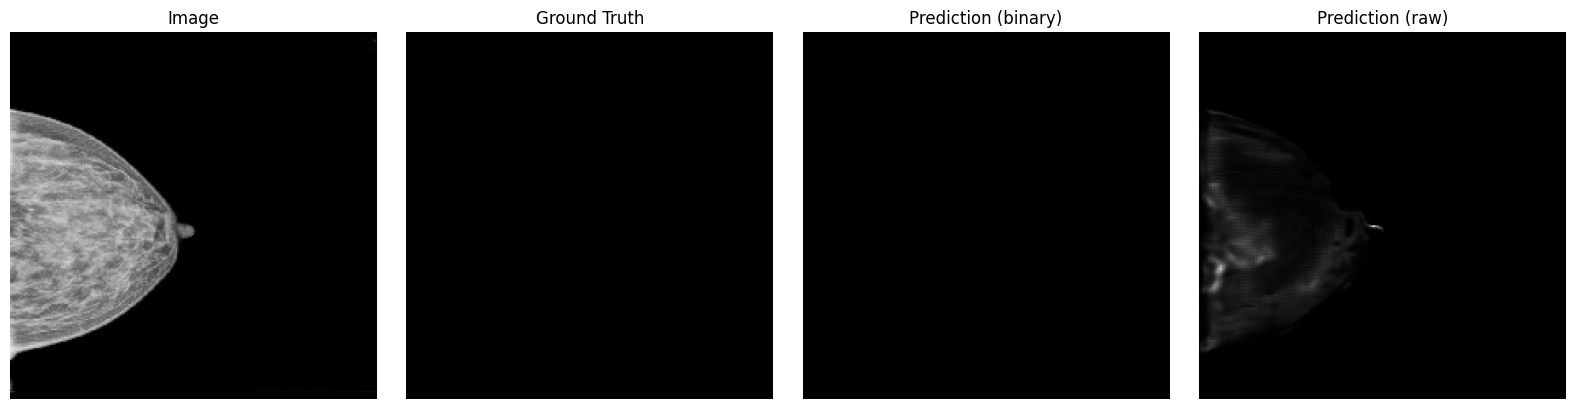

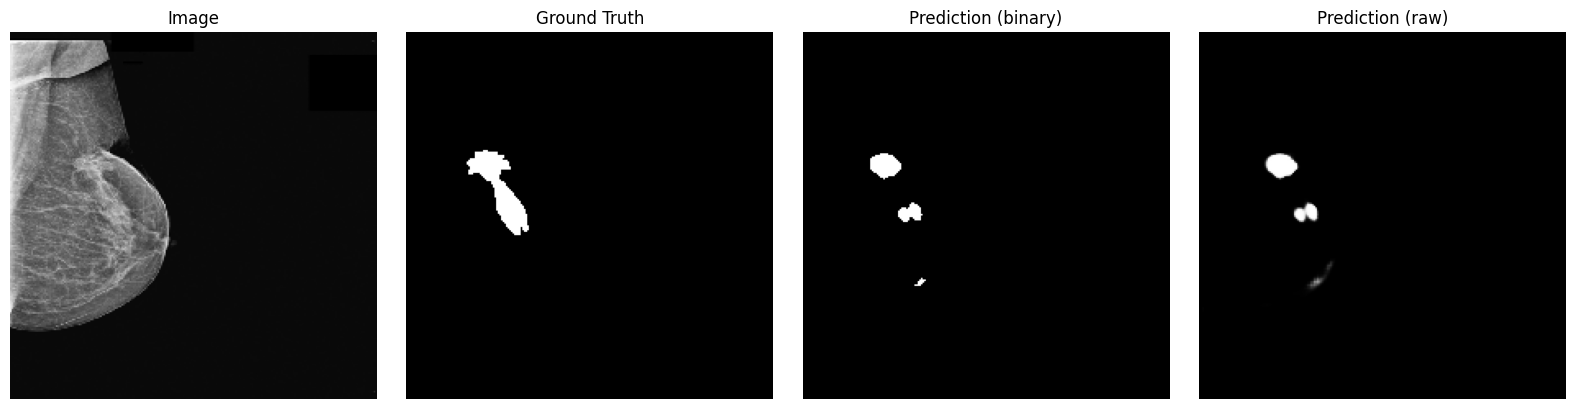

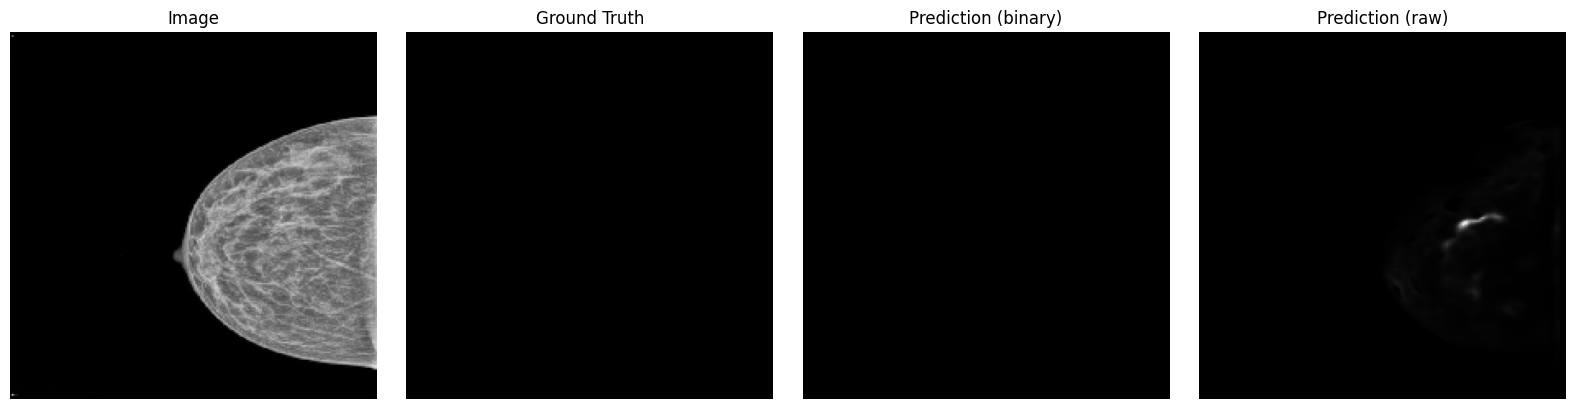

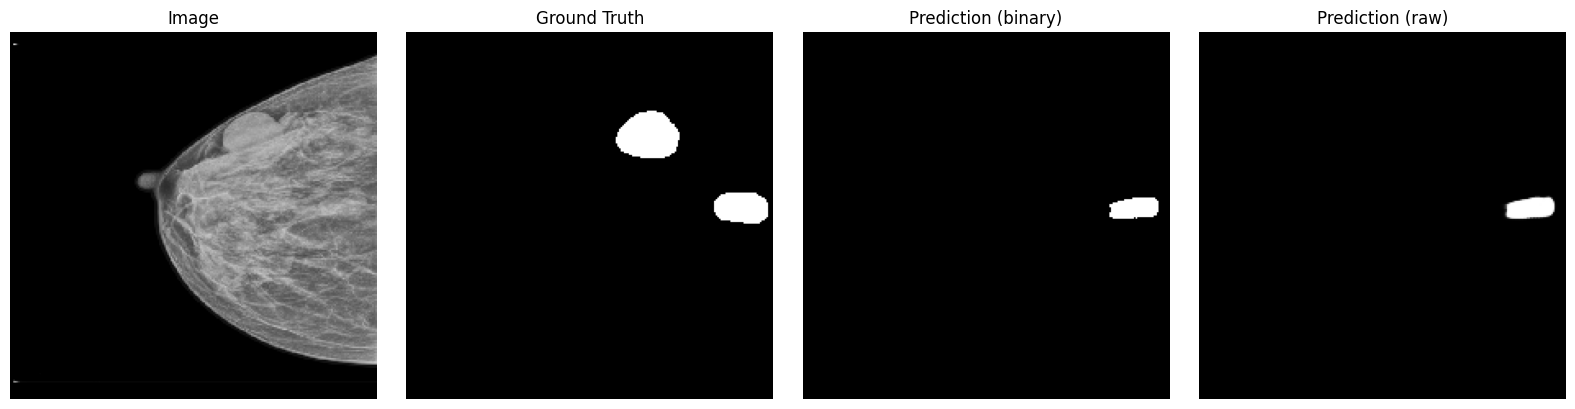

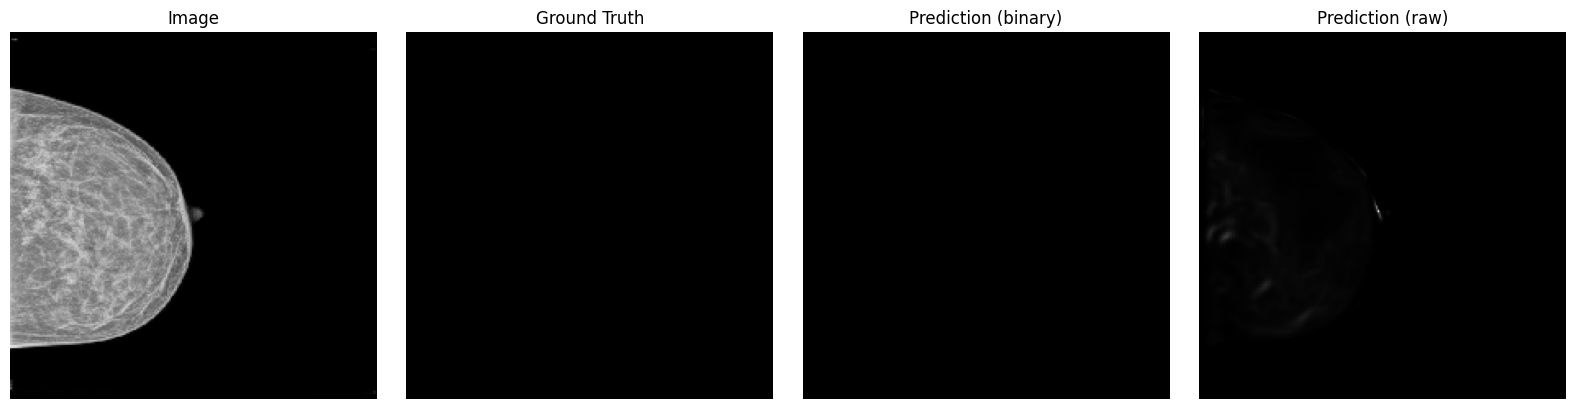

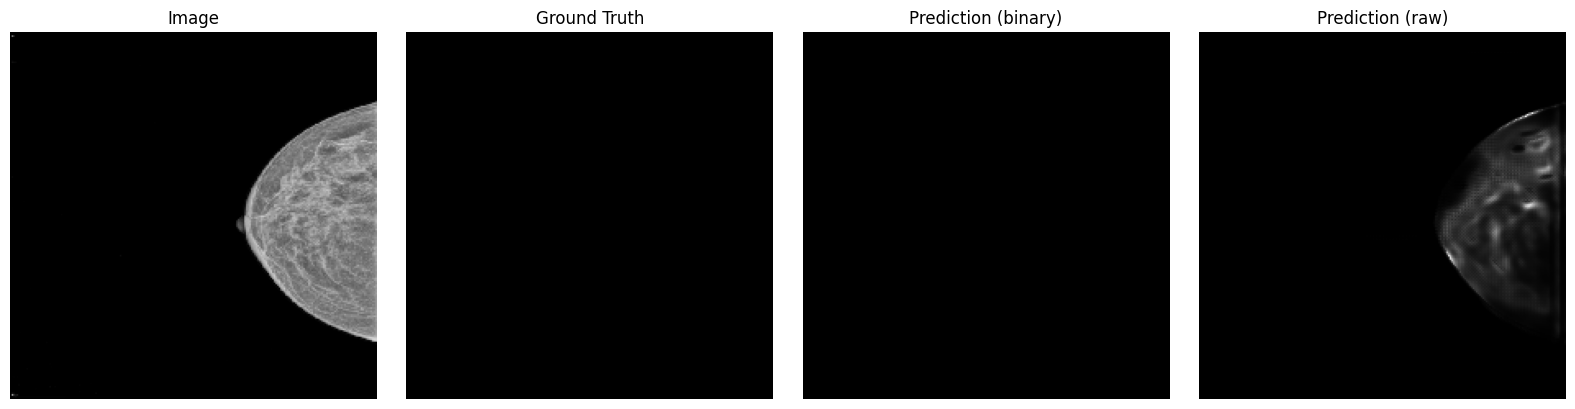

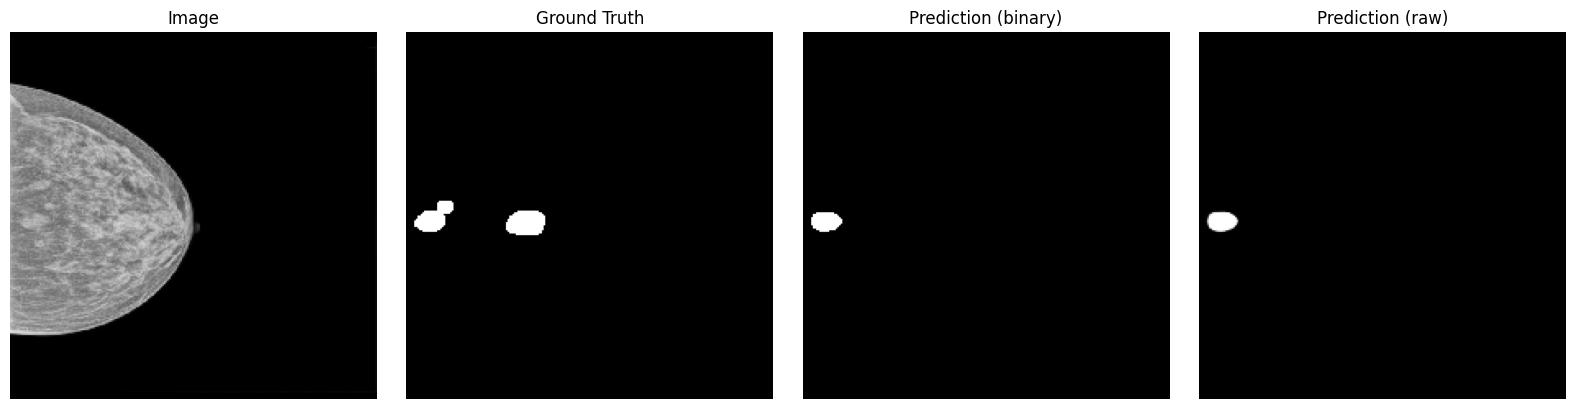

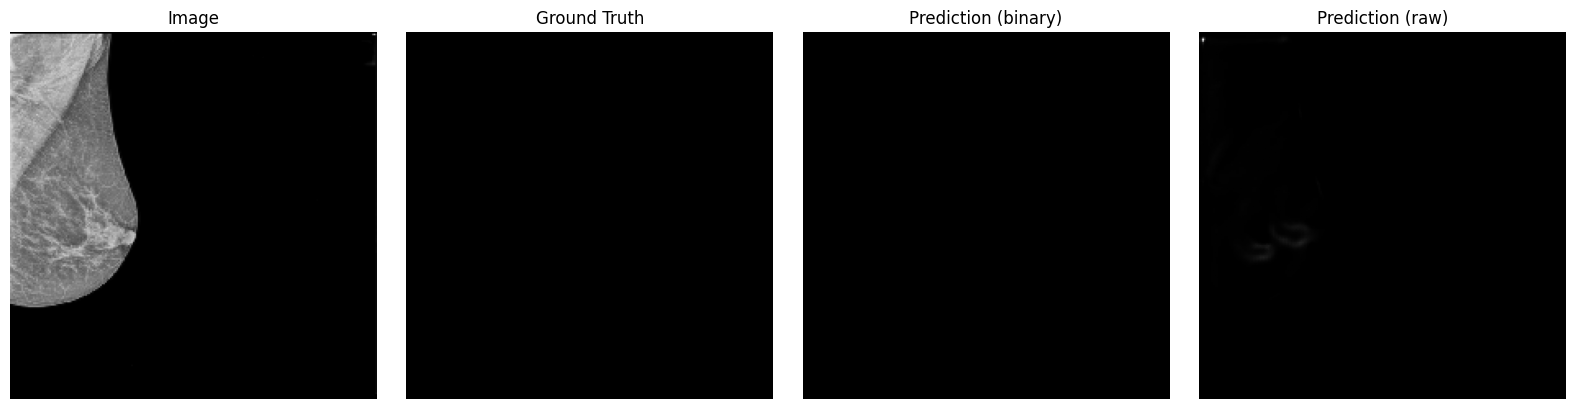

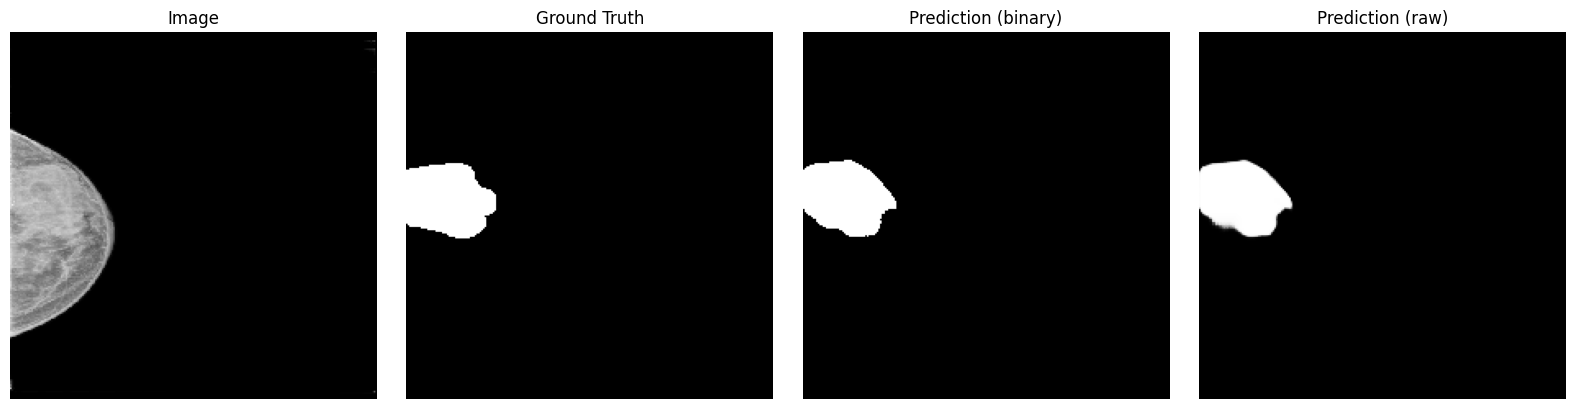

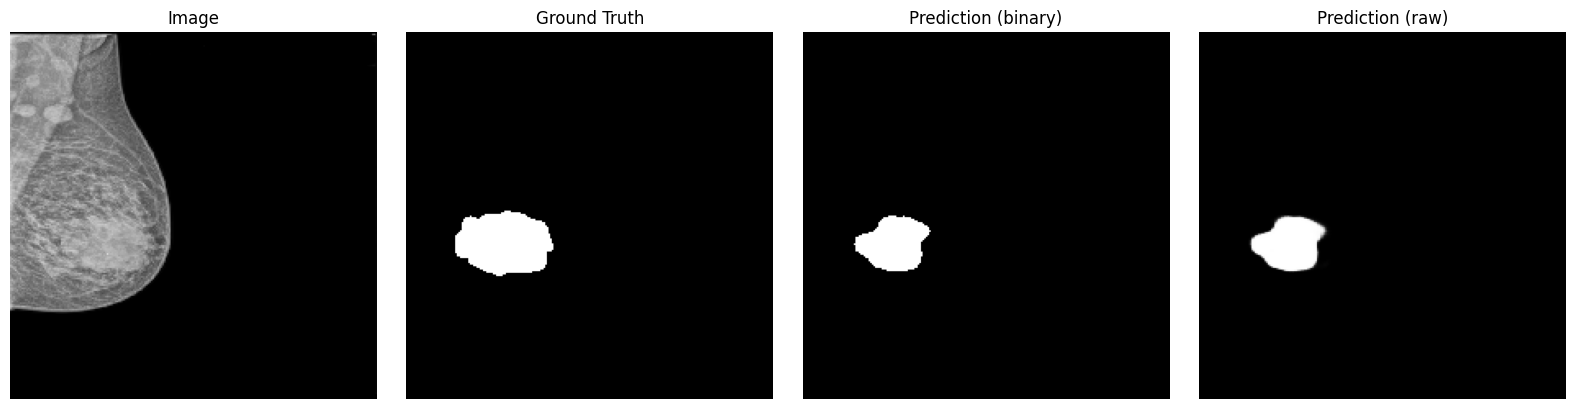

In [16]:
#for i in random.sample(range(1, len(X)), 20):
for i in range(0, 10):
    plt.figure(figsize=(16, 4))  # Wider figure to fit 4 subplots

    plt.subplot(1, 4, 1)
    plt.imshow(X[i])
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(y[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(preds_binary[i].squeeze(), cmap='gray')
    plt.title("Prediction (binary)")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title("Prediction (raw)")
    plt.axis('off')
    

    plt.tight_layout()
    plt.show()

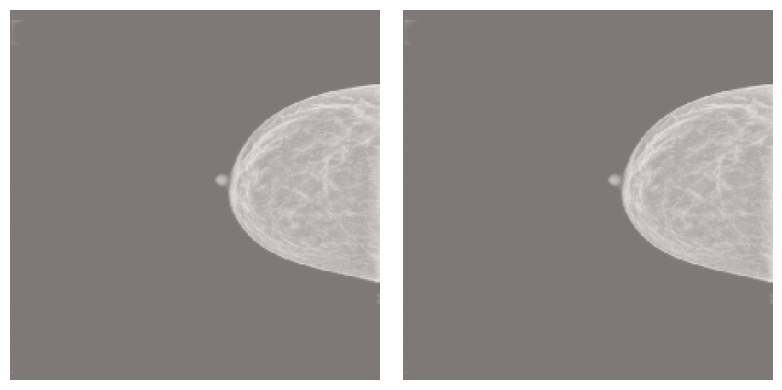

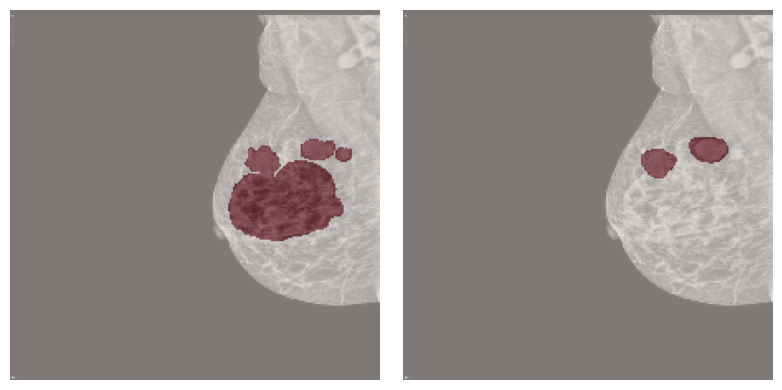

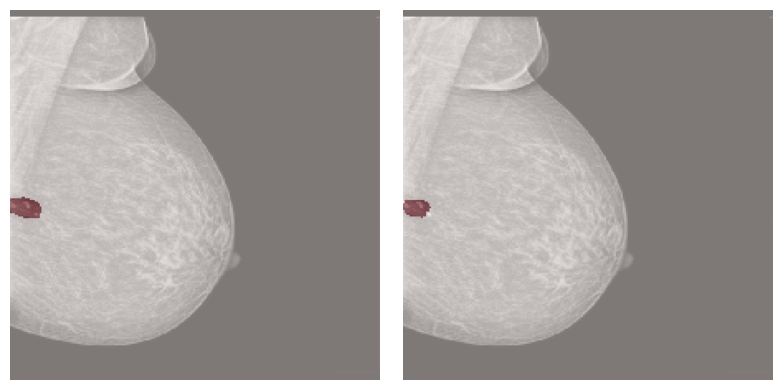

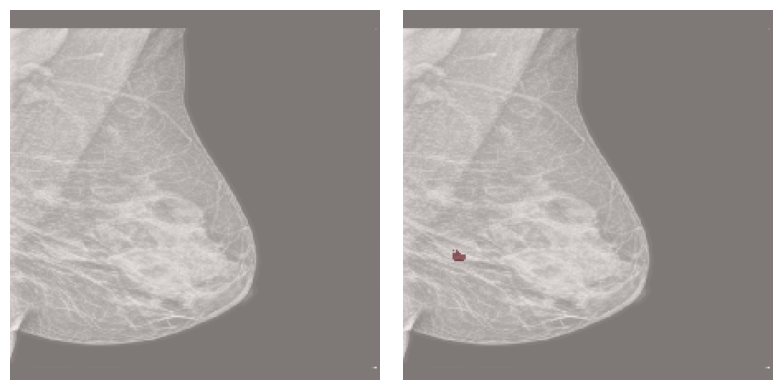

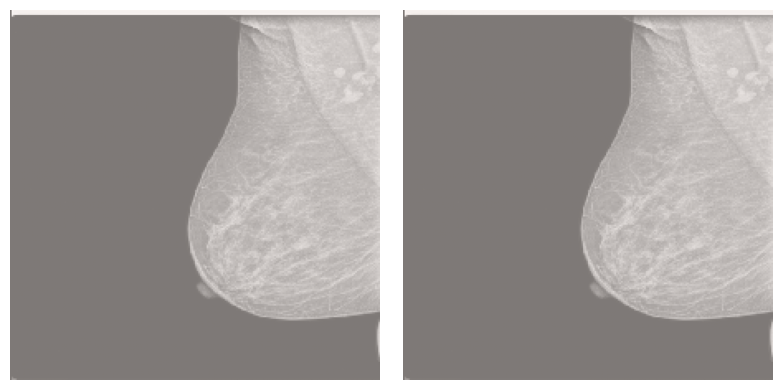

In [17]:
def plot_overlay(image, mask, alpha=0.5, mask_color='Reds'):
    """
    image: numpy array, shape (H, W, 3)
    mask: numpy array, shape (H, W) or (H, W, 1)
    alpha: transparency of the mask overlay
    mask_color: colormap for the mask (e.g., 'Reds', 'Greens', 'jet')
    """
    
    plt.imshow(image)
    plt.imshow(mask.squeeze(), cmap=mask_color, alpha=alpha)
    plt.axis('off')

    
for i in random.sample(range(1, len(X)), 5):
#for i in range(10, 20):
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plot_overlay(X[i], y[i])                     # Ground truth
    plt.subplot(1, 2, 2)
    plot_overlay(X[i], preds_binary[i])          # Binary prediction
    #plt.subplot(1, 3, 3)
    #plot_overlay(X[i], preds[i], alpha=0.3)      # Soft prediction
    
    plt.tight_layout()
    plt.show()

In [18]:
def iou_score(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)

    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()

    if union == 0:
        return float(intersection == 0)  # 1 if both are empty, else 0

    return intersection / union

def dice_score(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)

    intersection = np.logical_and(y_true, y_pred).sum()
    return (2. * intersection) / (y_true.sum() + y_pred.sum() + 1e-7)

score_iou = [iou_score(y[index], preds_binary[index]) for index in range(len(X))]
score_dice = [dice_score(y[index], preds_binary[index]) for index in range(len(X))]

print(f"Mean IoU:  {np.mean(score_iou):.3f}")
print(f"Mean Dice: {np.mean(score_dice):.3f}")

Mean IoU:  0.639
Mean Dice: 0.230


In [20]:
#from tensorflow.keras.models import save_model

#save_model(model, "../models/unet_seg_model_11_6_2025_3.keras")

## YOLOv8